# Machine Learning Lab 5
Williams Ubani


In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from pandas import *
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from tqdm.notebook import trange, tqdm

In [3]:
def normalizeAB(a,b,x):
    minX = x.min()
    maxX = x.max()
    return (b - a) * ((x - minX) / (maxX-minX)) + a

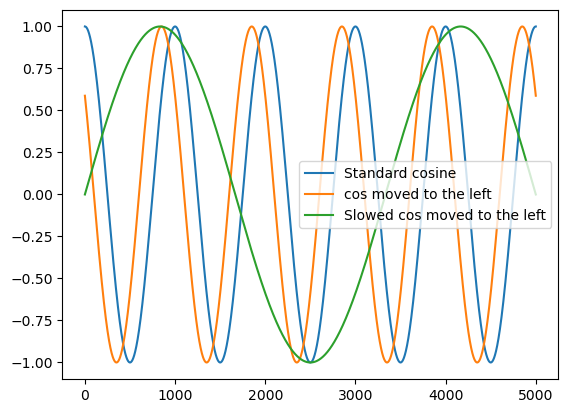

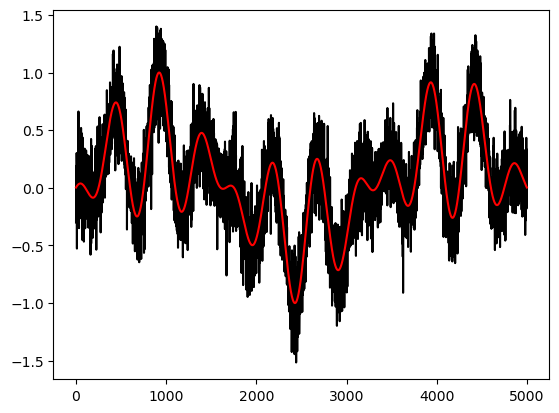

In [4]:
x = linspace(0, numpy.pi * 10, 5001)
A = numpy.cos(x)
B = numpy.cos(x + numpy.pi * 0.3)
C = numpy.cos((x + numpy.pi * 5) * 0.3) 
plot(A, label="Standard cosine")
plot(B, label="cos moved to the left")
plot(C, label="Slowed cos moved to the left")
legend()
figure()
rawData = normalizeAB(-1, 1, A * B * C)
noise = numpy.random.normal(0, 0.2, 5001)
data = rawData+noise
plot(data,'k')
plot(rawData,'r')

consider the first 3000 datapoints training data and the remaining 2000 test data

# RNN

In [5]:
class RNNModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=10, num_layers=1):
        super(RNNModel, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.recurrentLayer = nn.RNN(input_size, self.hidden_size, self.num_layers)
        self.outputLayer = nn.Linear(self.hidden_size, 1)
            
    def forward(self, x):                  
        if x.dim() == 2:
            h0 = torch.zeros(self.num_layers, self.hidden_size)
                
        if x.dim() == 3:
            h0 = torch.zeros(self.num_layers, x.shape[1], self.hidden_size)

        hidden, h0 = self.recurrentLayer(x,h0)
        
        return self.outputLayer(hidden)


# LSTM

In [6]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=10, num_layers=1):
        super(LSTMModel, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.recurrentLayer = nn.LSTM(input_size, self.hidden_size, self.num_layers)
        self.outputLayer = nn.Linear(self.hidden_size, 1)
            
    def forward(self, x):           
        
        if x.dim() == 2:
            h0 = (
                torch.zeros(self.num_layers, self.hidden_size),
                torch.zeros(self.num_layers, self.hidden_size)
            )               
        
        if x.dim() == 3:
            h0 = (
                torch.zeros(self.num_layers, x.shape[1], self.hidden_size),
                torch.zeros(self.num_layers, x.shape[1], self.hidden_size)
            )

        hidden, h0 = self.recurrentLayer(x,h0)
        
        return self.outputLayer(hidden)


In [7]:
def data_splitter(data, window_length):
    arr = []
    for i in range(len(data) - window_length):
        start_index = i
        end_index = i + window_length + 1
        arr.append(data[start_index:end_index])
    return np.array(arr)


data1 = data_splitter(data, 3)
training_data1, test_data1 = data1[:3000], data1[3000:]

data2 = data_splitter(data, 30)
training_data2, test_data2 = data2[:3000], data2[3000:]

data3 = data_splitter(data, 100)
training_data3, test_data3 = data3[:3000], data3[3000:]

data4 = data_splitter(data, 300)
training_data4, test_data4 = data4[:3000], data4[3000:]

In [8]:
def train(model, optimizer, criterion, dataset, n_epochs=50):
    model.train()
                
    epoch_loss = 0

    numpy.random.shuffle(dataset)

    for item in dataset:
        optimizer.zero_grad()

        inputs, desired_outputs = item[:-1], item[1:]
        outputs = model(torch.Tensor(inputs).reshape(-1, 1))
        loss = criterion(outputs, torch.Tensor(desired_outputs).reshape(-1, 1))

        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()

    return epoch_loss / len(dataset)
    

def test(model, criterion, dataset):
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
        for item in dataset:
            inputs, desired_outputs = item[:-1], item[1:]
            outputs = model(torch.Tensor(inputs).reshape(-1, 1))
            loss = criterion(outputs, torch.Tensor(desired_outputs).reshape(-1, 1))
            epoch_loss += loss.item()

    return epoch_loss / len(dataset)


In [9]:
def train_eval_loop(model, train_dataset, test_dataset, n_epochs=3):
    
    optimizer = optim.Adam(model.parameters())
    criterion = nn.MSELoss()

    avg_train_losses = []
    avg_test_losses = []
    for epoch in trange(n_epochs):   
        avg_train_loss = train(model, optimizer, criterion, train_dataset)
        avg_test_loss = test(model, criterion, test_dataset)
        print(f"Epoch {epoch + 1}\t Avg. Training Loss: {avg_train_loss:.4f}\t Avg. Test Loss: {avg_test_loss:.4f}")
        avg_train_losses.append(avg_train_loss)
        avg_test_losses.append(avg_test_loss)
        
    return avg_train_losses, avg_test_losses
        

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1	 Avg. Training Loss: 0.0861	 Avg. Test Loss: 0.0622
Epoch 2	 Avg. Training Loss: 0.0700	 Avg. Test Loss: 0.0588
Epoch 3	 Avg. Training Loss: 0.0677	 Avg. Test Loss: 0.0583


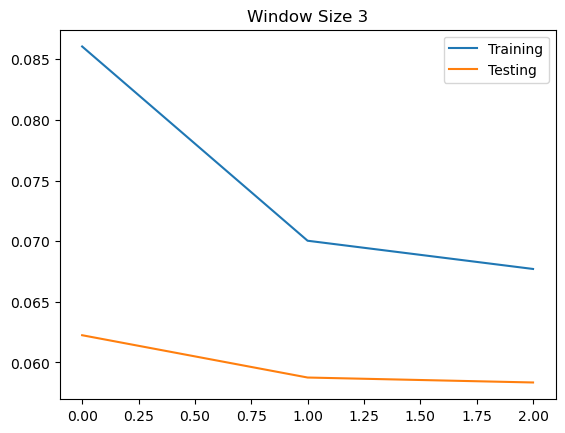

In [10]:
#Window Size 3 RNN
RNNModel = RNNModel()
avg_train_losses1, avg_test_losses1 = train_eval_loop(RNNModel, training_data1, test_data1)
plot(avg_train_losses1, label="Training")
plot(avg_test_losses1, label="Testing")
title("Window Size 3")
legend()

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1	 Avg. Training Loss: 0.0691	 Avg. Test Loss: 0.0496
Epoch 2	 Avg. Training Loss: 0.0570	 Avg. Test Loss: 0.0485
Epoch 3	 Avg. Training Loss: 0.0554	 Avg. Test Loss: 0.0478


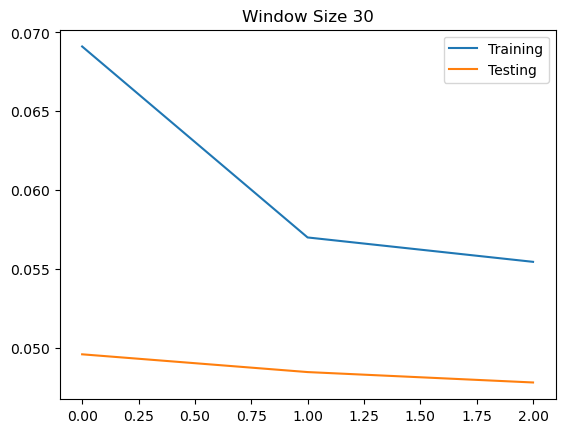

In [11]:
#Window size 30 RNN
avg_train_losses2, avg_test_losses2 = train_eval_loop(RNNModel, training_data2, test_data2)
plot(avg_train_losses2, label="Training")
plot(avg_test_losses2, label="Testing")
title("Window Size 30")
legend()

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1	 Avg. Training Loss: 0.0582	 Avg. Test Loss: 0.0438
Epoch 2	 Avg. Training Loss: 0.0493	 Avg. Test Loss: 0.0433
Epoch 3	 Avg. Training Loss: 0.0486	 Avg. Test Loss: 0.0429


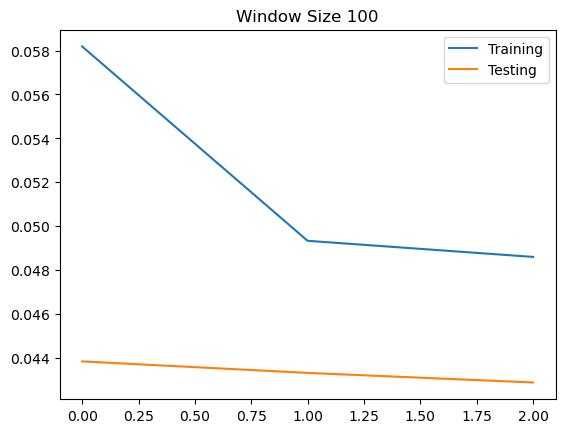

In [12]:
#Window size 100 RNN
avg_train_losses3, avg_test_losses3 = train_eval_loop(RNNModel, training_data3, test_data3)
plot(avg_train_losses3, label="Training")
plot(avg_test_losses3, label="Testing")
title("Window Size 100")
legend()

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1	 Avg. Training Loss: 0.0544	 Avg. Test Loss: 0.0422
Epoch 2	 Avg. Training Loss: 0.0475	 Avg. Test Loss: 0.0428
Epoch 3	 Avg. Training Loss: 0.0472	 Avg. Test Loss: 0.0413


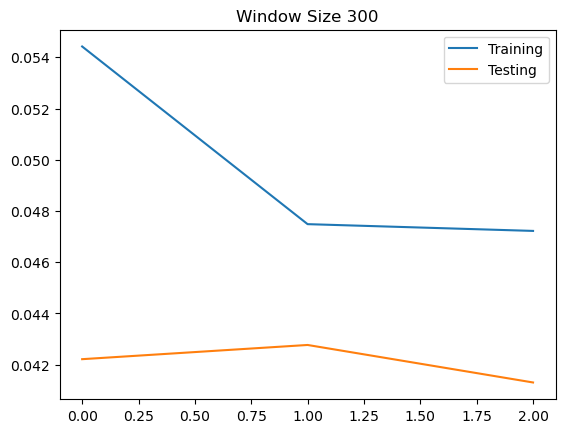

In [13]:
#window size 300 RNN
avg_train_losses4, avg_test_losses4 = train_eval_loop(RNNModel, training_data4, test_data4)
plot(avg_train_losses4, label="Training")
plot(avg_test_losses4, label="Testing")
title("Window Size 300")
legend()

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1	 Avg. Training Loss: 0.0996	 Avg. Test Loss: 0.0627
Epoch 2	 Avg. Training Loss: 0.0679	 Avg. Test Loss: 0.0577
Epoch 3	 Avg. Training Loss: 0.0670	 Avg. Test Loss: 0.0575


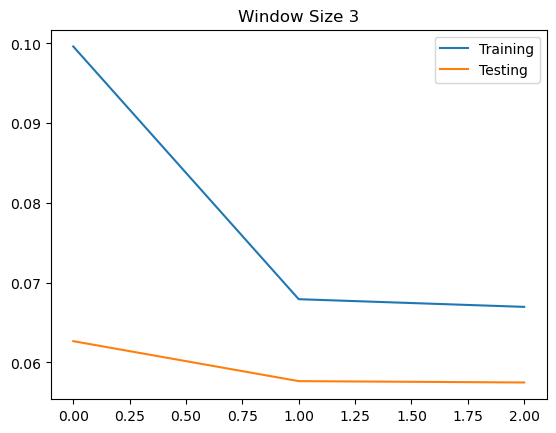

In [14]:
#window size 3 LSTM
LSTMModel = LSTMModel()
avg_train_losses5, avg_test_losses5 = train_eval_loop(LSTMModel, training_data1, test_data1)
plot(avg_train_losses5, label="Training")
plot(avg_test_losses5, label="Testing")
title("Window Size 3")
legend()

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1	 Avg. Training Loss: 0.0672	 Avg. Test Loss: 0.0456
Epoch 2	 Avg. Training Loss: 0.0507	 Avg. Test Loss: 0.0435
Epoch 3	 Avg. Training Loss: 0.0497	 Avg. Test Loss: 0.0435


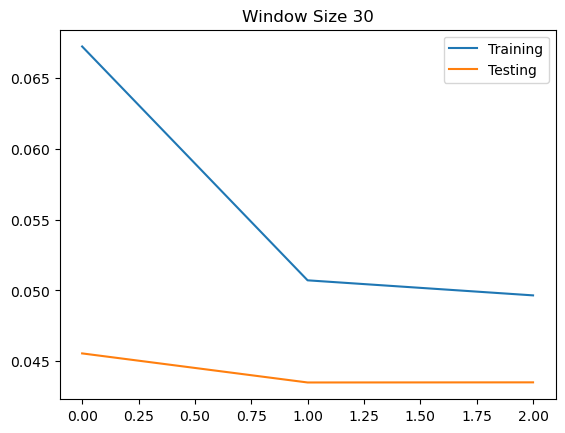

In [15]:
#Window size 30 LSTM
avg_train_losses6, avg_test_losses6 = train_eval_loop(LSTMModel, training_data2, test_data2)
plot(avg_train_losses6, label="Training")
plot(avg_test_losses6, label="Testing")
title("Window Size 30")
legend()

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1	 Avg. Training Loss: 0.0581	 Avg. Test Loss: 0.0439
Epoch 2	 Avg. Training Loss: 0.0481	 Avg. Test Loss: 0.0441
Epoch 3	 Avg. Training Loss: 0.0475	 Avg. Test Loss: 0.0418


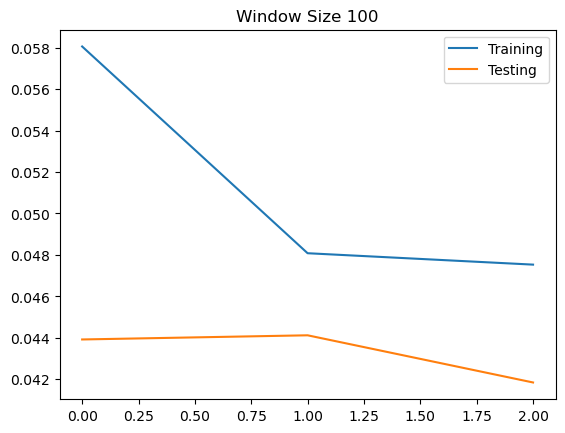

In [16]:
#window size 100
avg_train_losses7, avg_test_losses7 = train_eval_loop(LSTMModel, training_data3, test_data3)
plot(avg_train_losses7, label="Training")
plot(avg_test_losses7, label="Testing")
title("Window Size 100")
legend()

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1	 Avg. Training Loss: 0.0547	 Avg. Test Loss: 0.0408
Epoch 2	 Avg. Training Loss: 0.0462	 Avg. Test Loss: 0.0406
Epoch 3	 Avg. Training Loss: 0.0454	 Avg. Test Loss: 0.0407


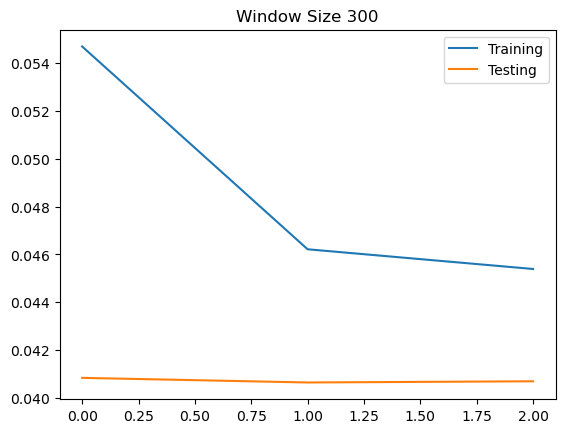

In [17]:
#Window size 300
avg_train_losses8, avg_test_losses8 = train_eval_loop(LSTMModel, training_data4, test_data4)
plot(avg_train_losses8, label="Training")
plot(avg_test_losses8, label="Testing")
title("Window Size 300")
legend()

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Predictions')

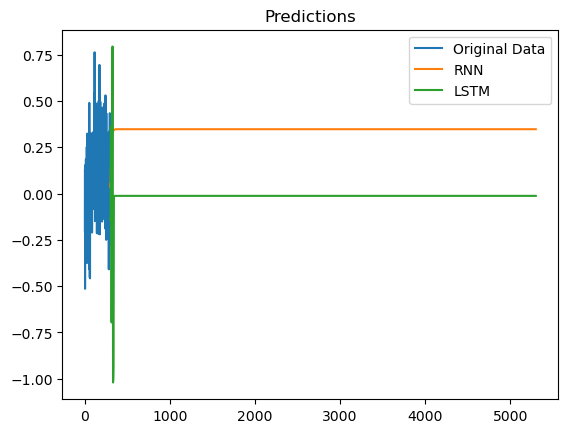

In [19]:
rnn = RNNModel
lstm = LSTMModel

next_data_rnn = rnn(torch.Tensor(test_data4[-1]).reshape(-1, 1))
next_data_lstm = lstm(torch.Tensor(test_data4[-1]).reshape(-1, 1))


values_rnn = numpy.array([])
values_lstm = numpy.array([])


for _ in trange(5000):
    next_data_rnn = rnn(torch.Tensor(next_data_rnn))
    values_rnn = numpy.append(values_rnn, next_data_rnn[-1].item())
    
for _ in trange(5000):
    next_data_lstm = lstm(torch.Tensor(next_data_lstm))
    values_lstm = numpy.append(values_lstm, next_data_lstm[-1].item())
    
plot(test_data4[-1], label="Original Data")
plot(numpy.arange(len(test_data4[-1]), len(test_data4[-1]) + len(values_rnn)), values_rnn, label="RNN")
plot(numpy.arange(len(test_data4[-1]), len(test_data4[-1]) + len(values_lstm)), values_lstm, label="LSTM")
legend()
title("Predictions")

The LSTM appears to have a better prediction horizon in the picture compared to the RNN. This interpretation is based on the visual representation where the RNN prediction seems to quickly converge to a constant value (the orange line), suggesting it cannot capture longer dependencies in the data or adjust to new patterns over the extended horizon. In contrast, the LSTM's prediction (the green line) remains more dynamic and close to the original data for a longer period before eventually converging, indicating a better capability to model temporal dependencies and provide a more meaningful prediction over a longer horizon.